In [111]:
import Pkg; Pkg.add("Plots"); Pkg.add("LaTeXStrings"); Pkg.add("FFTW");

using Printf
using Plots
using LaTeXStrings
using LinearAlgebra
using FFTW

# Based on 'Realistic Ocean Simulation using Fourier Transform' by Saulius Vincevičius

g = 9.81

   Resolving package versions...
  No Changes to `C:\Users\rober\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\rober\.julia\environments\v1.11\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\rober\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\rober\.julia\environments\v1.11\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\rober\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\rober\.julia\environments\v1.11\Manifest.toml`


9.81

$$
g = \text{gravity}\\
\bm{k} = (k_x, k_y) = \text{wave vector}\\
k = \text{magnitude of wave vector}\\
\text{Wave vector components are }[-\pi, \pi]\\
k_x = 2\pi\frac{x-\frac{l}{2}}{l}\\
k_y = 2\pi\frac{y-\frac{l}{2}}{l}\\
l = \text{length scale of ocean}\\
\text{x} = (x, y) = \text{Coordinate in output texture}
$$

$$
\text{Dispersion relation in deep water}\\
ω^2=gk\\
$$

$$\textbf{\huge JONSWAP Spectrum}$$
Joint North Sea Wave Project. An improvement over the Pierson-Moskowitz spectrum as it does not assume that the sea is fully developed by adding a peak enhancement factor $\gamma^r$.
$$
F = \text{fetch (distance to leeward shore)}\\
U_{10} = \text{Wind speed at 10m above sea level}
$$

$$
\text{Peak Dispersion Relation}\\
ω_p = 22\left(\frac{g^2}{U_{10}F} \right)^{1/3}
$$

In [112]:
ω_p(speed, fetch) = 22 * (g^2 / (speed * fetch))^(1 / 3)

ω_p (generic function with 1 method)

$$
\text{Intensity}\\
α =  0.076\left(\frac{U_{10}^2}{Fg}\right)^{0.22}
$$

In [113]:
α(speed, fetch) = 0.076 * (speed^2/(fetch*g))^0.22

α (generic function with 1 method)

$$
\text{JONSWAP exponent}\\
r = \exp(-\frac{(\omega-\omega_p)^2}{2\sigma^2\omega_p^2})
$$

In [114]:
r(ω, ω_p, σ) = exp(-(ω - ω_p)^2 / (2 * σ^2 * ω_p^2))

r (generic function with 1 method)

$$
σ = \begin{cases}
0.07  & \text{if } ω \leq ω_p,\\
0.09  & \text{if } ω \gt ω_p.
\end{cases}
%$

In [115]:
σ(ω, ω_p) = begin
    if (ω <= ω_p)
        0.07
    else
        0.09
    end
end

σ (generic function with 1 method)

$$
S_{J} = \frac{αg^2}{ω^5}\exp\left(-\frac{5}{4}\left(\frac{ω_p}{ω}\right)^4\right)γ^r
$$

In [116]:
jonswap(ω, speed, fetch) = begin
    α_val = α.(speed, fetch)
    ω_p_val = ω_p.(speed, fetch)
    σ_val = σ.(ω, ω_p_val) # Broadcasting to compare each ω with ω_p_val
    r_val = r.(ω, ω_p_val, σ_val)
    γ = 3.3
    α_val .* g .^ 2 ./ ω .^ 5 .* exp.(-5 / 4 .* (ω_p_val ./ ω) .^ 4) .* γ .^ r_val
end

jonswap (generic function with 1 method)

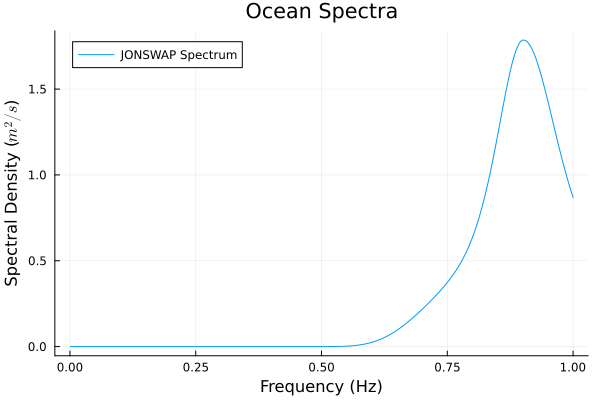

In [117]:
wind_speed = 14
fetch = 100_000.0
ω = LinRange(0.0, 1.0, 1028)

v = jonswap.(ω, wind_speed, fetch)
replace!(v, NaN=>0)

plot(ω, jonswap.(ω, wind_speed, fetch), label="JONSWAP Spectrum", legend=:topleft)
title!("Ocean Spectra")
xlabel!("Frequency (Hz)")
ylabel!(L"Spectral Density ($m^2/s$)")

$$\text{\Large The Texel MARSEN ARSLOE (TMA) Spectrum}$$
JONSWAP only applies to deep water so we need to apply a correction factor to it so that we can use it in shallow waters. The TMA spectrum can be created by applying the Kitaigordskii depth Attenuation function which can be approximated as:

$$
ϕ(ω, h) \approx \begin{cases}
		\frac{1}{2}ω_h^2		& \text{if } ω_h \leq 1,\\
		1-\frac{1}{2}(2-ω_h)^2  & \text{if } 1 \lt ω_h.\\
	  \end{cases}\\
ω_h = ω\sqrt{h/g}
$$

However, because we want to be able to use this in deep waters as well, we should stop the attenuation factor from affecting the spectrum once it has reached it's peak by adding:
$$
ϕ(ω, h) \approx \begin{cases}
		1		& \text{if } 2.0 \leq ω_h\\
	  \end{cases}\\
$$

In [ ]:
ϕ(ω, h) = begin
    ω_h = ω * sqrt(h / g)
    if (ω_h <= 1)
        0.5 * ω_h^2
    elseif (ω_h <= 2)
        1 - 0.5 * (2 - ω_h)^2
    else 
        1.0
    end
end

ϕ (generic function with 1 method)

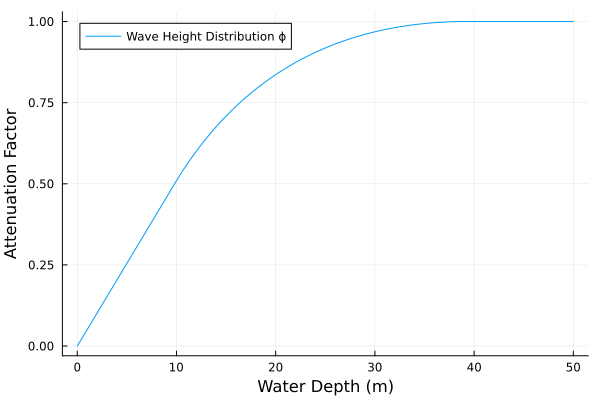

In [119]:
h = 0.0:0.1:50.0
ω = 1.0
ω_h = 0.0:0.01:2.0

# plot(ω_h, ϕ.(ω_h), label="Wave Height Distribution")
plot(h, ϕ.(ω, h), label="Wave Height Distribution ϕ")
xlabel!("Water Depth (m)")
ylabel!("Attenuation Factor")

$$\text{\Large Donelan-Banner Directional Spreading}$$
We need to add directionality to the TMA spectrum. Donelan-Banner Directional Spreading can do this:

$$
D(ω, θ) = \frac{β_s}{2\text{tanh}(β_sπ)}\text{sech}(β_sθ)^2\\

β_s = \begin{cases}
		2.61(ω/ω_p)^{1.3}	& \text{if } 0.56 \lt ω/ω_p \leq 0.95,\\
		2.28(ω/ω_p)^{-1.3}  & \text{if } 0.95 \lt ω/ω_p \leq 1.6,\\
		10^{ϵ}  			& \text{if } 1.6  \lt ω/ω_p.\\
	  \end{cases}\\
ϵ = -0.4 + 0.8393 e^{-0.567\ln(ω/ω_p)^2}\\
θ = \arctan(k.y/k.x)-θ_{wind}
$$

In [120]:
relative_wind_angle(k, θ_wind) = begin
    θ = atan(k[2], k[1]) - θ_wind
    if θ > π
        θ -= 2 * π
    elseif θ < -π
        θ += 2 * π
    end
    θ
end

β_s(ω, ω_p) = begin
    ratio = ω / ω_p
    if ratio < 0.56
        # 0 #?
        2.61 * 0.56^1.3
    elseif ratio <= 0.95
        2.61 * ratio^1.3
    elseif ratio <= 1.6
        2.28 * ratio^-1.3
    else
        ϵ = -0.4 + 0.8393 * exp(-0.567 * log(ratio)^2)
        10^ϵ
    end

end

D(ω, ω_p, θ) = begin
    β_s_val = β_s.(ω, ω_p)
    d = β_s_val .* sech.(β_s_val * θ)^2 ./ (2 * tanh.(β_s_val * π))
    # replace!(d, NaN => 0)
    d
end

D (generic function with 1 method)

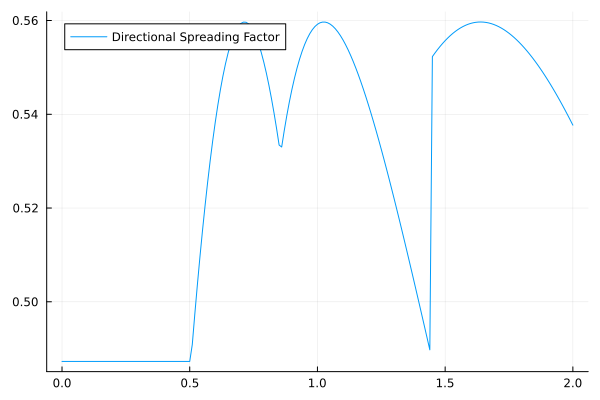

In [121]:
ω = 0.0:0.01:2.0

plot(ω, D.(ω,ω_p(wind_speed, fetch), 0.4), label="Directional Spreading Factor")

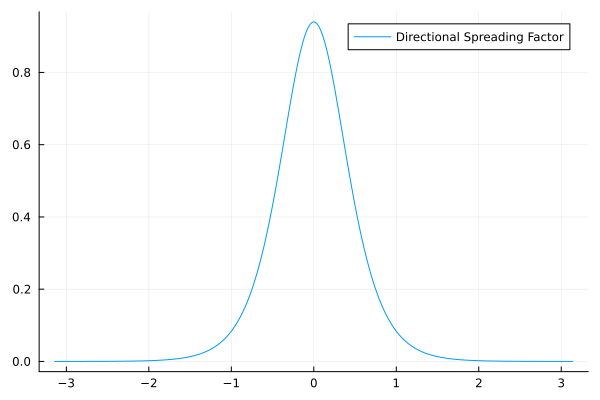

In [122]:
θ = -π:0.01:π

plot(θ, D.(0.7,ω_p(wind_speed, fetch), θ), label="Directional Spreading Factor")

Now we need to combine it all and make it a function of **k** instead of ω.

$$
S(\bm{k}) = 2 \cdot S_{J}(ω, U_{10}, F) \cdot ϕ(ω, h) \cdot D(ω, θ) \cdot \frac{dω}{dk}/k \cdot Δk_x \cdot Δk_y\\

\frac{dω}{dk} = \frac{g}{2\sqrt{gk}}
$$

In [ ]:
dω_dk_k(k_mag) = begin
    if k_mag == 0
        0
    else
        g / (2 * sqrt(g * k_mag)) / k_mag
    end
end

# Final Wave Spectrum
# k - 2d array of wave vectors in each direction
# U - wind speed
# F - leeward fetch distance
# θ - angle of wind relative to the wave direction
# h - water depth
S(k, U, F, θ, h) = begin
    k_mag = mapslices(norm, k, dims=3)[:, :]
    ω = sqrt.(g * k_mag)
    ω_p_val = ω_p(U, F)

    S_j = jonswap(ω, U, F)
    replace!(S_j, NaN => 0)

    Δk_x = k[2, 1, 1] - k[1, 1, 1]
    Δk_y = k[1, 2, 2] - k[1, 1, 2]

    2 * Δk_x * Δk_y * S_j .* ϕ.(ω, h) .* D(ω, ω_p_val, θ) .* dω_dk_k.(k_mag)
end

S (generic function with 1 method)

This function is our final 2D wave spectrum with directionality but is still not ready for feeding into the inverse FFT as plotting it will show

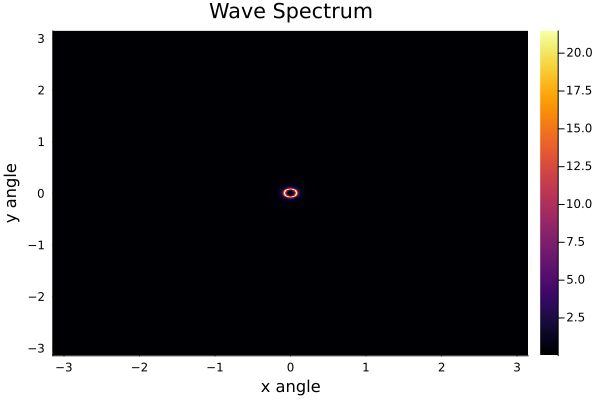

In [ ]:
resolution = 512

angles = LinRange(-π, π, resolution)
k  = zeros(Float64, (resolution, resolution, 2))
for i in 1:resolution
	for j in 1:resolution
		k[i, j, 1] = angles[i]
		k[i, j, 2] = angles[j]
	end
end

θ = 0

S_val = S(k, wind_speed, fetch, θ, 60)

heatmap(
	angles,
    angles, 
	# data,
	S_val,
    # c=cgrad([:blue, :white,:red, :yellow]),
    xlabel="x angle", ylabel="y angle",
    title="Wave Spectrum")

Our current spectrum $S(\bm{k})$ is a power spectrum so does not contain any indormation on the phase of the waves. We can add this back with:
$$
h̃_0(\bm{k})=\frac{1}{\sqrt{2}}(ξ_r+ξ_i)\sqrt{S(\bm{k})}\\
ξ_r+ξ_i \text{ is a complex number generated from a Gaussian distribution with a mean of 0 and standard deviation of 1.}\\
$$

To give the spectrum a dependency on time, we can combine it with its conjugate:
$$
h̃(\bm{k}, t)=h̃_0(\bm{k})e^{iω(k)t}+h̃_0^*(-\bm{k})e^{-iω(k)t}
$$

This function can be fed into the Inverse Discrete Fourier Transform to give us out height map, with x representing the 2D position in the height texture:
$$
h(\text{x})=\sum_{k}h̃(\bm{k}, t)e^{i\bm{k}\cdot \text{x}}
$$

In [125]:
h_0_tilde(k, U, F, θ, h) = begin
    h_out = zeros(ComplexF64, (resolution, resolution))
    s = S(k, U, F, θ, h)
    for i in 1:resolution
        for j in 1:resolution
            h_out[i, j] = 1 / sqrt(2) * (randn() + randn() * im) * sqrt(s[i, j])
        end
    end
    h_out
end

# Fourier Spectrum
# k - 2d array of wave vectors in each direction
# U - wind speed0
# F - leeward fetch distance
# θ - angle of wind relative to the wave direction
# h - water depth
# t - time
h_tilde(k, U, F, θ, h, t) = begin
    k_mag = mapslices(norm, k, dims=3)[:, :]
    ω = sqrt.(g * k_mag)
    # display(h_0_tilde(k, U, F, θ, h))

    h_0_tilde(k, U, F, θ, h) .* exp.(im * t * ω) + conj(h_0_tilde(-k, U, F, θ, h)) .* exp.(-im * t * ω)
    # h_0_tilde(k, U, F, θ, h) + conj(h_0_tilde(-k, U, F, θ, h))
end

h_tilde (generic function with 1 method)

This is now ready to be converted into a height map, but it's still worth plotting to see the changes we made

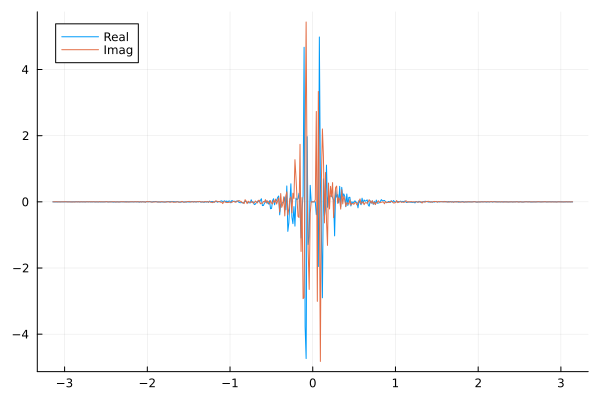

In [ ]:
h_val = h_tilde(k, wind_speed, fetch, θ, 60, 0.0)

plot(angles, real(h_val[trunc(Int, resolution/2),:]), label="Real", legend=:topleft)
plot!(angles, imag(h_val[trunc(Int, resolution/2),:]), label="Imag", legend=:topleft)

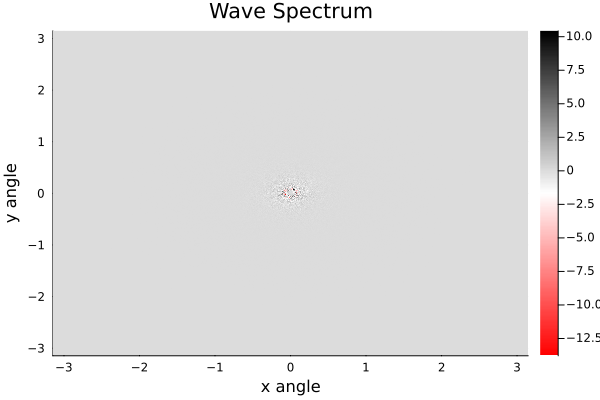

In [127]:
heatmap(
    angles,
    angles,
    real(h_val),
    c=cgrad([:red, :white, :black]),
    xlabel="x angle", ylabel="y angle",
    title="Wave Spectrum")

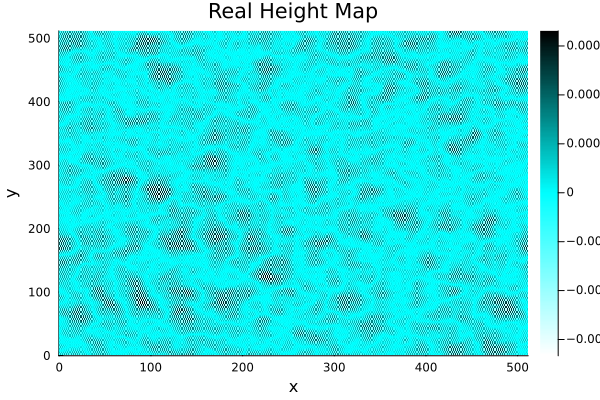

In [134]:
ih = ifft(h_val)
x = 0:1:resolution-1

heatmap(
	x,
    x, 
	real(ih),
    c=cgrad([:white, :cyan, :black]),
    xlabel="x", ylabel="y",
    title="Real Height Map")

# heatmap(
# 	x,
#     x, 
# 	imag(ih),
#     c=cgrad([:white, :cyan, :black]),
#     xlabel="x", ylabel="y",
#     title="Imaginary Height Map")

Now that we have our height map, we need a normal map for calculating reflections

In [129]:
normal(k, h) = begin
	im * k .* h
end

normal (generic function with 1 method)

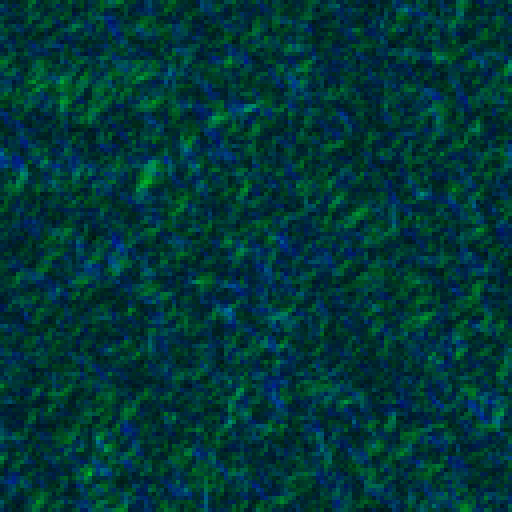

┌ Warning: Output swatches are reduced due to the large size (512×512).
│ Load the ImageShow package for large images.
└ @ Colors C:\Users\rober\.julia\packages\Colors\E2qak\src\display.jl:159


In [130]:
n = normal(k, h_val)

in = ifft(n).*10000
in_img = [RGB(0,norm(in[x, y, 1]), norm(in[x, y, 2])) for x in 1:resolution, y in 1:resolution]